<a href="https://colab.research.google.com/github/opalinav/Dynamic-Bayesian-Networks/blob/main/CellRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellRank Meets Experimental Time

## Preliminaries

Skeleton based of off CellRank tutorial:  (https://github.com/theislab/cellrank_notebooks/blob/main/tutorials/kernels/500_real_time.ipynb).

In this tutorial, you will learn how to:

- match cells across experimental time points using a {class}`~moscot.problems.time.TemporalProblem` {cite}`klein:23`.
- set up a {class}`~cellrank.kernels.RealTimeKernel` to combine transitions within- and across time-points.
- visualize these transitions in a low dimensional embedding.


:::{figure-md} moscot-cellrank

<img src="../_static/img/500_moscot_to_cellrank.jpg" alt="Moscot and CellRank interface to analyze dynamics in complex spatio-temporal datasets." width="800px">

**The Moscot/CellRank interface:** Any type of temporal {mod}`moscot` problem, including the {class}`~moscot.problems.time.TemporalProblem`, the {class}`~moscot.problems.time.LineageProblem` (see [moslin](https://github.com/theislab/moslin)) and the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`, can be passed to CellRank for further analysis {cite}`lange:23, klein:23`.
:::



:::{note}
If you want to run this on your own data, you will need:

- a scRNA-seq dataset with experimental time points. Additional spatial or lineage information improves the accuracy of fate mapping, but is not required.

:::

### Import packages & data

In [ ]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 27.6 MB/s eta 0:00:00
  Preparing

# **Instructions:**
After running the cell below click the 'restart runtime' button below the cell (if it shows up)

In [ ]:
pip install moscot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from moscot.problems.time import TemporalProblem

import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [ ]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
import pandas as pd
import io
from google.colab import files
import scanpy as sc

In [ ]:
tutorial=False


## Choose Adata object


In [ ]:
def data(tutorial, name='linstep_data2.csv'):
  if tutorial==True:
    adata = cr.datasets.reprogramming_schiebinger(subset_to_serum=True)
    t='day'
  else:
    uploaded = files.upload()
    linstep=pd.read_csv(io.BytesIO(uploaded[name]))
    linstep['Synapse_name']=['synapse_'+ str(i) for i in range(1,len(linstep)+1)]
    proteins=linstep[linstep.columns[1:-2]]
    time=linstep['Time']
    names=linstep['Synapse_name']
    adata=sc.AnnData(X=proteins.values)
    adata.obs['time'] = linstep['Time'].values
    adata.obs_names = names
    adata.var_names=linstep.columns[1:-2]
    t='time'
  return adata,t



In [ ]:
linstep=pd.read_csv('linstep_data2.csv')

In [ ]:
linstep

,Unnamed: 0,A,B,C,D,E,F1,G,H,I,J,Time
0,1,2.839555e-02,0.019167,0.022668,0.018694,0.026428,0.058887,0.054617,0.033270,0.038664,0.039729,5
1,2,3.761801e-03,0.002766,0.003089,0.002246,0.002626,0.001484,0.001573,0.002891,0.001531,0.002425,5
2,3,4.510217e-02,0.030491,0.037809,0.026735,0.034924,0.024005,0.024063,0.035850,0.022688,0.034101,5
3,4,4.669224e-04,0.000314,0.000373,0.000465,0.001924,0.054302,0.048051,0.013502,0.016244,0.028489,5
4,5,7.632801e-03,0.007539,0.007072,0.007269,0.006108,0.005902,0.005782,0.007508,0.006283,0.011634,5
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39996,3.532238e-03,0.003578,0.003555,0.003593,0.003562,0.003593,0.003600,0.003562,0.003610,0.003578,40
39996,39997,2.874221e-12,0.000028,0.000014,0.000037,0.000019,0.000037,0.000042,0.000019,0.000047,0.000028,40
39997,39998,5.296553e-01,0.529585,0.529620,0.529562,0.529609,0.529562,0.529550,0.529609,0.529536,0.529585,40
39998,39999,4.555548e-05,0.000049,0.000048,0.000051,0.000048,0.000051,0.000051,0.000048,0.000052,0.000049,40


In [ ]:
adata,t=data(tutorial)

Saving linstep_data2.csv to linstep_data2.csv


In [ ]:
t

'time'

In [ ]:
adata

AnnData object with n_obs × n_vars = 40000 × 10
    obs: 'time'

In [ ]:
adata.X

array([[2.83955497e-02, 1.91671625e-02, 2.26682884e-02, ...,
        3.32696744e-02, 3.86644516e-02, 3.97293969e-02],
       [3.76180108e-03, 2.76586968e-03, 3.08948732e-03, ...,
        2.89132632e-03, 1.53094765e-03, 2.42506951e-03],
       [4.51021683e-02, 3.04913780e-02, 3.78087742e-02, ...,
        3.58496482e-02, 2.26882361e-02, 3.41011604e-02],
       ...,
       [5.29655254e-01, 5.29585349e-01, 5.29620301e-01, ...,
        5.29608643e-01, 5.29535785e-01, 5.29585330e-01],
       [4.55554759e-05, 4.94522515e-05, 4.75041077e-05, ...,
        4.81588696e-05, 5.22444912e-05, 4.94653786e-05],
       [1.27440648e-03, 1.27464368e-03, 1.27452508e-03, ...,
        1.27456459e-03, 1.27481177e-03, 1.27464362e-03]])

Massage the time point annotations.

In [ ]:
adata.obs[t] = adata.obs[t].astype(float).astype("category")

# In addition, it's nicer for plotting to have numerical values.
adata.obs[t+"_numerical"] = adata.obs[t].astype(float)

Subsample to speed up the analysis - this tutorial is meant to run in a couple of minutes on a laptop. It’s not a problem for CellRank to do any of the computations here on the full data, we’d just have to wait a bit longer.

In [ ]:
if tutorial:
  sc.pp.subsample(adata, fraction=0.25, random_state=0)
adata

AnnData object with n_obs × n_vars = 40000 × 10
    obs: 'time', 'time_numerical'

### SKIP THIS CELL Visualize the embedding

Let’s visualize this data, using the original force-directede layout {cite}`schiebinger:19`.

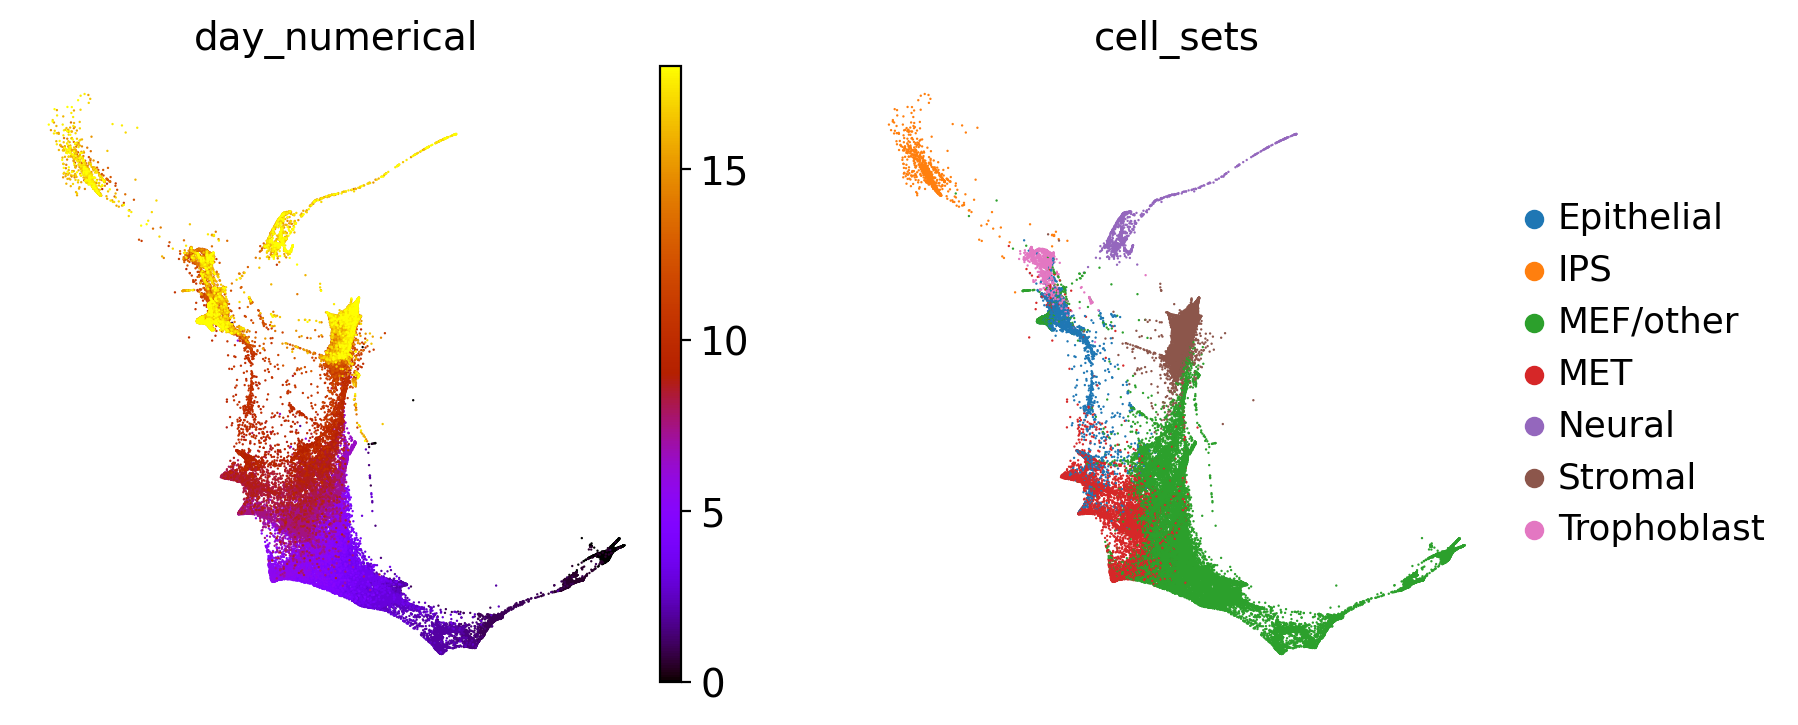

In [ ]:
if tutorial:
  sc.pl.embedding(
      adata,
      basis="force_directed",
      color=["day_numerical", "cell_sets"],
      color_map="gnuplot",
  )

Each dot is a cell in the force-direction embedding, colored according to one of the 39 time-points of sequencing, from early (day 0, in black) to late (day 18, in yellow) (left) or coarse cell-set annotations (right). We created the `cell_sets` annotation by slightly modifying and combining the original annotations, introducing a `MEF/other` category that didn't exist in the original data {cite}`schiebinger:19`.

### Preprocess the data

This datset has already been normalized by total counts and log2-transformed. Further, highly variable genes have already been annotated. We can thus direclty compute a {func}`PCA representation <scanpy.pp.pca>` and a {func}`k-NN graph <scanpy.pp.neighbors>`, which we'll need later on.

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=0)

## Reconstruct differentiation trajectories across time points

### Run moscot to couple cells

With {mod}`moscot`, we couple cells across time points using [optimal transport](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)) (OT), as pioneered by [Waddington-OT](https://broadinstitute.github.io/wot/) {cite}`schiebinger:19`. {mod}`moscot` scales to millions of cells and supports multi-modal data {cite}`klein:23`. We demonstrate the most basic use-case here: linking a smaller-scale unimodal scRNA-seq dataset across experimental time points.

:::{note}
moscot can do much more! To learn how to incorporate multimodal information, millions of cells, and additional spatial information, check out the [documentation](https://moscot-tools.org), including many [tutorials](https://moscot.readthedocs.io/en/latest/notebooks/tutorials/index.html). Additionally, to include lineage-traced data, check out the moscot-lineage ([moslin](https://github.com/theislab/moslin)) [tutorial](https://moscot.readthedocs.io/en/latest/notebooks/tutorials/100_lineage.html).
    
Importantly, everything we demonstrate here works exactly the same if you include these additional data modalities! The couplings just get better, and additional downstream analysis becomes available.

:::

The first step is to set up a {class}`~moscot.problems.time.TemporalProblem`. If you have additional spatial or lineage information, you can use the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem` or the {class}`~moscot.problems.time.LineageProblem`, respectively.

In [ ]:
tp = TemporalProblem(adata)

Next, we adjust the marginals for cellular growth- and death using {meth}`~moscot.problems.time.TemporalProblem.score_genes_for_marginals`.

In [ ]:
if tutorial:
  tp = tp.score_genes_for_marginals(
      gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
  )

Visualize the computed proliferation and apoptosis scores in the embedding.

In [ ]:
if tutorial:
  sc.pl.embedding(
    adata, basis="force_directed", color=["cell_sets", "proliferation", "apoptosis"]
)

Following the original Waddington OT publication, we use local PCAs, computed separately for each pair of time points, to calulate distances among cells {cite}`schiebinger:19`. Accordingly, we prepare the {class}`~moscot.problems.time.TemporalProblem` without passing a `joint_attr`, this automatically computes local PCAs.

In [ ]:
tp = tp.prepare(time_key=t)

INFO     Ordering Index(['synapse_1', 'synapse_2', 'synapse_3', 'synapse_4', 'synapse_5',                          
                'synapse_6', 'synapse_7', 'synapse_8', 'synapse_9', 'synapse_10',                                  
                ...                                                                                                
                'synapse_39991', 'synapse_39992', 'synapse_39993', 'synapse_39994',                                
                'synapse_39995', 'synapse_39996', 'synapse_39997', 'synapse_39998',                                
                'synapse_39999', 'synapse_40000'],                                                                 
               dtype='object', name='Synapse_name', length=40000) in ascending order.                              


In the final step, we solve one OT problem per time point pair, probabilistically matching early to late cells {cite}`peyre:19`.

In [ ]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `7` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5000, 5000)].                                  


Above, `epsilon` and `tau_a` control the amount of entropic regularization and unbalancedness on the source marginal, respectively. Higher entropic regularization speeds up the optimization and improves statistical properties of the solution {cite}`cuturi:13`; unbalancedness makes the solution more robust with respect to uncertain cellular growth rates and biased cell sampling {cite}`schiebinger:19, chizat:18`.

### Set up the RealTimeKernel

The {class}`~cellrank.kernels.RealTimeKernel` is CellRank's interface with time-course data; it can load cellular couplings computed with {mod}`moscot` or [Waddington OT](https://broadinstitute.github.io/wot/).

In [ ]:
tmk = RealTimeKernel.from_moscot(tp)

To get from a set of OT transport maps to a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) describing a biological system, we do the following:

1. we sparsify OT transport maps by removing entries below a certain threshold; entropic regularization yields dense matrices which would make CellRank analysis very slow.
2. we use OT transport maps and molecular similarity to model transitions across and within time points, respectively.
3. we row-normalize the resulting cell-cell transition matrix (including all time points) and construct the Markov chain.  

In [ ]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

  0%|          | 0/7 [00:00<?, ?time pair/s]

Using automatic `threshold=3.452232026089917e-23`


RealTimeKernel[n=40000, threshold='auto', self_transitions='all']

In [ ]:
adata

AnnData object with n_obs × n_vars = 40000 × 10
    obs: 'time', 'time_numerical'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
matrix=tmk.transition_matrix

In [ ]:
matrix

<40000x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 94947072 stored elements in Compressed Sparse Row format>

In [ ]:
print(matrix)

  (0, 9999)	2.5423185388772108e-09
  (0, 9998)	2.7182383784273834e-06
  (0, 9996)	1.770250464813989e-05
  (0, 9995)	5.625533508561333e-05
  (0, 9993)	3.3576108408542455e-19
  (0, 9992)	4.91461061492262e-05
  (0, 9990)	1.896670112734103e-06
  (0, 9989)	7.8474077942041e-07
  (0, 9986)	1.9412862130855176e-09
  (0, 9985)	7.790659104716295e-15
  (0, 9984)	2.7568519303681943e-05
  (0, 9983)	0.000212386814762241
  (0, 9982)	1.5697674030736036e-09
  (0, 9981)	2.8980371435431916e-08
  (0, 9980)	5.84892871821776e-08
  (0, 9979)	8.977808225662979e-08
  (0, 9978)	4.770420096811079e-10
  (0, 9975)	1.3738339037679278e-06
  (0, 9974)	0.0012906758149515264
  (0, 9973)	0.00012291513660477743
  (0, 9972)	6.738504095697759e-10
  (0, 9971)	1.1945212413582993e-09
  (0, 9970)	2.550148638173157e-12
  (0, 9969)	6.176371035339799e-07
  (0, 9966)	5.211954343640709e-09
  :	:
  (39998, 37381)	0.011699439274445205
  (39998, 37237)	0.05681972516396898
  (39998, 37036)	0.0474668219902386
  (39998, 36958)	0.063715261

In [ ]:
type(matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
import scipy.sparse

In [ ]:
scipy.sparse.save_npz('sparse_matrix2.npz', matrix)

### Visualize the recovered dynamics

We can visualize the cellular dynamics described by this Markov chain by sampling {meth}`random walks <cellrank.kernels.RealTimeKernel.plot_random_walks>`.

Simulating `100` random walks of maximum length `500`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:37)
Plotting random walks


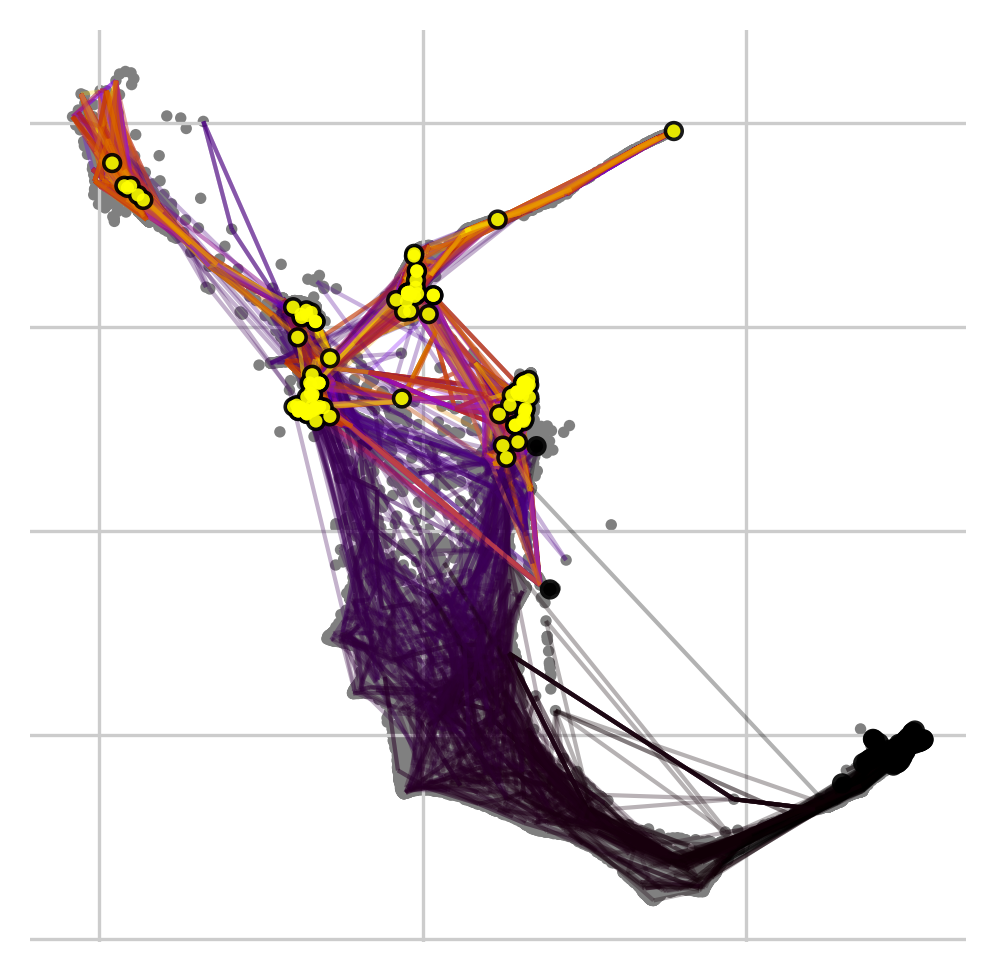

In [ ]:
if tutorial:
  tmk.plot_random_walks(
      max_iter=500,
      start_ixs={"day": 0.0},
      basis="force_directed",
      seed=0,
      dpi=150,
      size=30,
  )

Black and yellow dots denote random walks starting and finishing points, respectively. Random walks mostly finish in the iPSC, Neural, Stromal, Trophoblast and Epithelial cell sets.

Another way to visualize the reconstructed dynamics is by plotting the probability mass flow in time {cite}`mittnenzweig:21`.  

Computing flow from `MEF/other` into `2` cluster(s) in `38` time points
Plotting flow from `MEF/other` into `2` cluster(s) in `38` time points


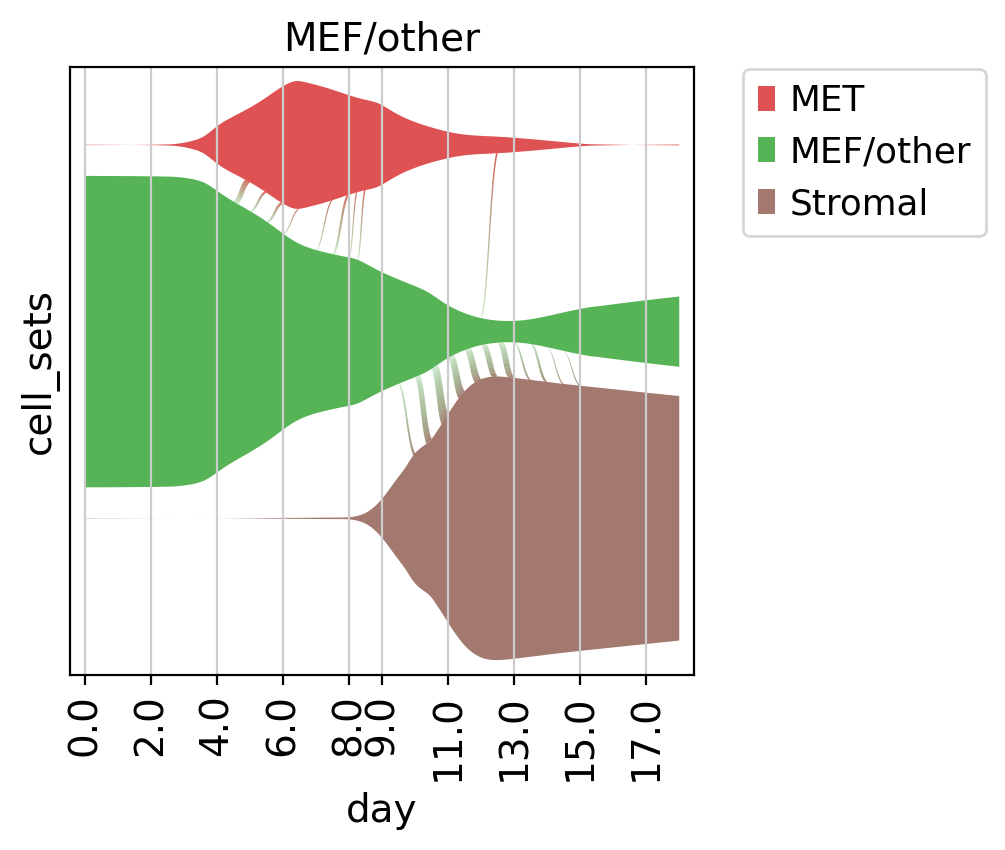

In [ ]:
if tutorial:
  ax = tmk.plot_single_flow(
      cluster_key="cell_sets",
      time_key="day",
      cluster="MEF/other",
      min_flow=0.1,
      xticks_step_size=4,
      show=False,
      clusters=["MEF/other", "MET", "Stromal"],
  )

  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Closing matters

### What's next?

In this tutorial, you learned how CellRank can be used to compute a transition matrix based on experimental time points and how the transition matrix can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly in high dimensions. For the next steps, we recommend to:

- go through the {doc}`initial and terminal states tutorial <../estimators/600_initial_terminal>` to learn how to use the transition matrix to automatically identify initial and terminal states.
- take a look at the {class}`API <cellrank.kernels.RealTimeKernel>`to learn about parameters you can use to adapt these computations to your data, and trying this out on your own data.
- read the Waddington-OT paper or the {mod}`moscot` preprint to learn more about linking cells across time points {cite}`schiebinger:19,klein:23`.

### Package versions

In [ ]:
cr.logging.print_versions()

cellrank==2.0.2 scanpy==1.9.6 anndata==0.10.3 numpy==1.24.4 numba==0.58.1 scipy==1.11.4 pandas==2.1.3 pygpcca==1.0.4 scikit-learn==1.2.2 statsmodels==0.14.0 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.7.1 seaborn==0.12.2
